# Categorical-only Article Clustering

This notebook clusters H&M articles using only categorical product attributes (no text features).

- Uses categorical encodings from the articles dataset
- Finds an optimal number of clusters via the elbow method
- Performs clustering and interprets clusters using product metadata
- Visualises clusters with PCA and t‑SNE

All identifiers, comments, and Markdown use UK spellings.


In [2]:
# Imports and configuration
import sys
sys.path.append('../') 
import os
import polars as pl
import numpy as np

from hnm_data_analysis.feature_engineering.categorical_features import ArticleCategoricalEncoder
from hnm_data_analysis.clustering.article_clustering import ArticleClusterer, ClusteringConfig

# Set absolute project paths
BASE_DIR = "/Users/tom/Data Analysis Projects/h_and_m_data_analysis"
ARTICLES_PATH = f"{BASE_DIR}/data/cleaned/articles_last_3_months_cleaned.parquet"
CATEGORICAL_DIR = f"{BASE_DIR}/data/processed/categorical_features"
RESULTS_DIR = f"{BASE_DIR}/results/categorical_clustering"

os.makedirs(CATEGORICAL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Base directory:", BASE_DIR)


Base directory: /Users/tom/Data Analysis Projects/h_and_m_data_analysis


In [3]:
# 1) Encode categorical features only
encoder = ArticleCategoricalEncoder(
    input_path=ARTICLES_PATH,
    encoding_strategy="mixed",       # one-hot for low-cardinality, label for high-cardinality
    handle_rare_categories="group",  # group rare categories as 'Other'
    rare_threshold=0.001
)

encoder.load_data()
X_cat = encoder.fit_transform(scale_features=True)
encoder.save_features(CATEGORICAL_DIR)

print("Categorical matrix:", X_cat.shape)


Loading articles from: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/data/cleaned/articles_last_3_months_cleaned.parquet
Loaded 42,298 articles with 28 columns
Found 12 categorical columns: ['product_code', 'prod_name', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no']
Dropping product_code: too many unique values (20981)
Dropping prod_name: too many unique values (21219)
Encoding config: 7 one-hot, 3 label, 0 ordinal
Grouped 4 rare categories in graphical_appearance_no as 'Other'
Grouped 8 rare categories in colour_group_code as 'Other'
Grouped 2 rare categories in perceived_colour_value_id as 'Other'
Grouped 3 rare categories in perceived_colour_master_id as 'Other'
One-hot encoded 7 columns into 131 features
Grouped 61 rare categories in product_type_no as 'Other'
Grouped 80 rare categories in department_no as 'Other

In [4]:
# 2) Prepare clusterer using only categorical features
# We'll create a minimal ArticleClusterer-like workflow without combining TF-IDF

# Save a temporary .npy features file and aligned article_id index for reuse with ArticleClusterer
combined_features_path = f"{BASE_DIR}/data/processed/categorical_features/categorical_only_features.npy"
article_index_path = f"{BASE_DIR}/data/processed/categorical_features/categorical_article_id_index.csv"

np.save(combined_features_path, X_cat)
print("Saved:", combined_features_path)
print("Using index:", article_index_path)

clusterer = ArticleClusterer(
    features_path=combined_features_path,
    article_ids_path=article_index_path,
    articles_metadata_path=ARTICLES_PATH
)

clusterer.load_features()
clusterer.load_articles_metadata()

# 3) Find optimal k via elbow (K-means inertia)
optimal_k, scores = clusterer.find_optimal_k(k_range=(3, 20), algorithm="kmeans")
print("Optimal k:", optimal_k)
print("Elbow scores (inertia):", scores)


Saved: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/data/processed/categorical_features/categorical_only_features.npy
Using index: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/data/processed/categorical_features/categorical_article_id_index.csv
Loaded features: 42,298 articles x 134 features
Loaded articles metadata: 42,298 articles
Finding optimal k using elbow method with kmeans...
k=3: elbow score = 5409964.7561
k=4: elbow score = 5301012.5104
k=5: elbow score = 5239890.5591
k=6: elbow score = 5151342.3634
k=7: elbow score = 5068756.0244
k=8: elbow score = 5002090.4889
k=9: elbow score = 4920688.8108
k=10: elbow score = 4840420.9680
k=11: elbow score = 4749700.1508
k=12: elbow score = 4703798.9421
k=13: elbow score = 4651496.2844
k=14: elbow score = 4593491.3400
k=15: elbow score = 4527847.7404
k=16: elbow score = 4496673.9789
k=17: elbow score = 4434364.8560
k=18: elbow score = 4379023.1753
k=19: elbow score = 4334939.9398
k=20: elbow score = 4281225.0005
Opti

In [5]:
# 4) Cluster with K-means using the selected k
config = ClusteringConfig(
    algorithm="kmeans",
    n_clusters=optimal_k,
    random_state=42
)

results = clusterer.cluster(config)

# 5) Interpret clusters
summaries = clusterer.interpret_clusters()
print("\nCluster summaries (truncated):")
for cid, s in list(summaries.items())[:5]:
    print(f"Cluster {cid}: size={s['size']} ({s['percentage']:.1f}%)")


Performing kmeans clustering...
Clustering completed: 4 clusters
Silhouette Score: 0.0449
Calinski-Harabasz Index: 975.8195
Davies-Bouldin Index: 4.2484

Cluster summaries (truncated):
Cluster 0: size=5850 (13.8%)
Cluster 1: size=23055 (54.5%)
Cluster 2: size=4670 (11.0%)
Cluster 3: size=8723 (20.6%)


Creating 2D visualization using PCA...
Saved cluster visualization to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/categorical_clustering/clusters_pca.png


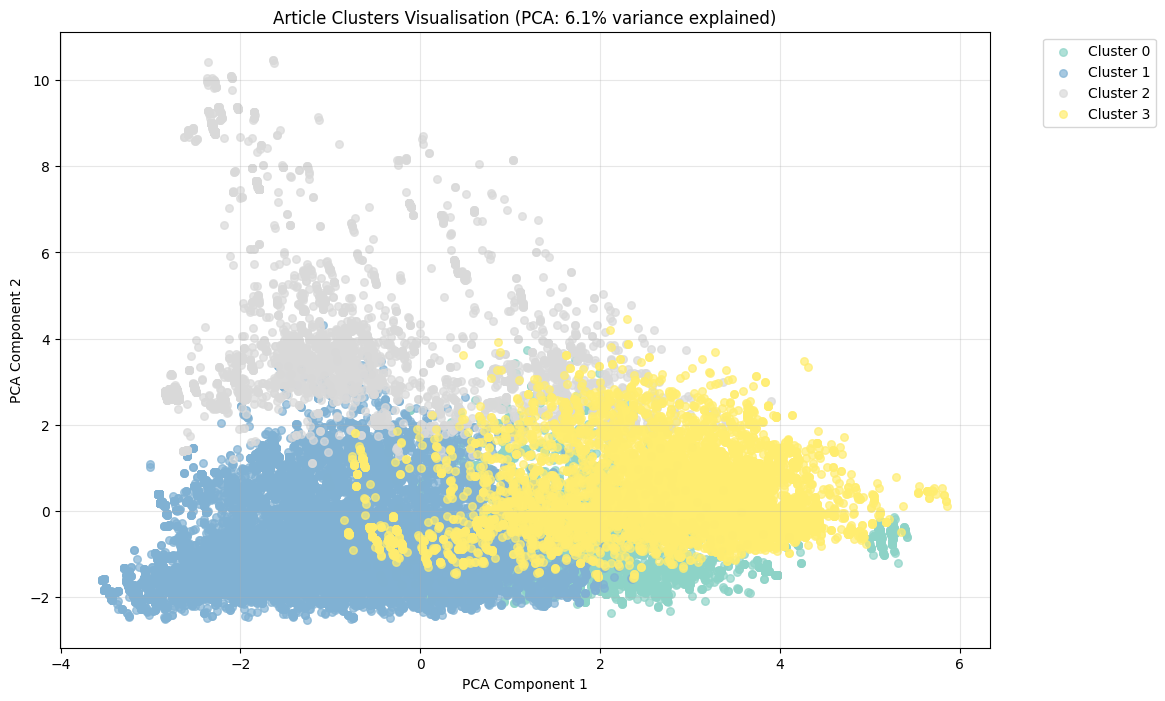

Creating 2D visualization using TSNE...
Saved cluster visualization to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/categorical_clustering/clusters_tsne.png


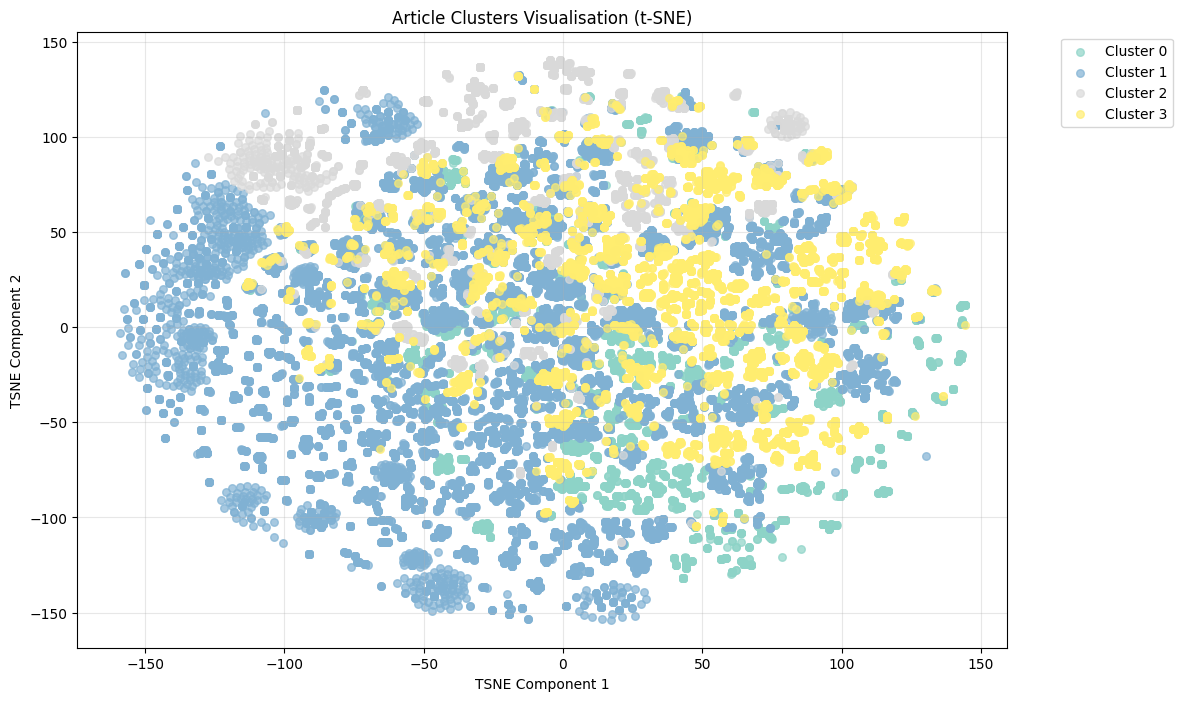

In [6]:
# 6) Visualisations
clusterer.visualise_clusters(method="pca", save_path=f"{RESULTS_DIR}/clusters_pca.png")
clusterer.visualise_clusters(method="tsne", save_path=f"{RESULTS_DIR}/clusters_tsne.png")


In [7]:
# 7) Save results
clusterer.save_results(RESULTS_DIR)
print("Saved results to:", RESULTS_DIR)


Saved cluster labels to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/categorical_clustering/cluster_labels.csv
Saved clustering model to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/categorical_clustering/clustering_model.joblib
Saved results metadata to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/categorical_clustering/clustering_results.json


TypeError: Object of type Series is not JSON serializable